# Set carbon emission targets

In this notebook a target for the emission is set and the required tax rate is calculated. This involves inverting the model, and takes some time.  

In [1]:
# Import modelflow

%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

from ipywidgets import interact,Dropdown,Checkbox
from IPython.display import display, clear_output,Latex, Markdown
import pandas as pd

import modelmf
import modeljupyter as mj
from modelvis import waterplot

from modelinvert import targets_instruments
from modelclass import model
model.widescreen()

model.scroll_off()

In [3]:
# Load model and data, and run 

masia,baseline = model.modelload('Asia_sep7.pcim',run=1,silent=1)
from inject import inject
inject(masia)  
masia.lastdf = masia.basedf.copy()

# Parameters in this simulation 
Singapore won't solve. So it is excluded 


In [4]:
countries_of_interest = [country for country in masia.countries_ASEAN if country not in ['SGP']]
                         
instruments = [[f'{country}_GCARBR_A'] for country in countries_of_interest]
target_var  = [f'{country}_CO2' for country in countries_of_interest]
delay = 2
reduction_percent = 30 
countries_of_interest

['BRN', 'KHM', 'IDN', 'LAO', 'MYS', 'MMR', 'PHL', 'THA', 'VNM']

# The instrument variables

In [5]:
print(instruments)

[['BRN_GCARBR_A'], ['KHM_GCARBR_A'], ['IDN_GCARBR_A'], ['LAO_GCARBR_A'], ['MYS_GCARBR_A'], ['MMR_GCARBR_A'], ['PHL_GCARBR_A'], ['THA_GCARBR_A'], ['VNM_GCARBR_A']]


# The target variables

In [6]:
print(target_var)

['BRN_CO2', 'KHM_CO2', 'IDN_CO2', 'LAO_CO2', 'MYS_CO2', 'MMR_CO2', 'PHL_CO2', 'THA_CO2', 'VNM_CO2']


# Emission in Business as usual scenario

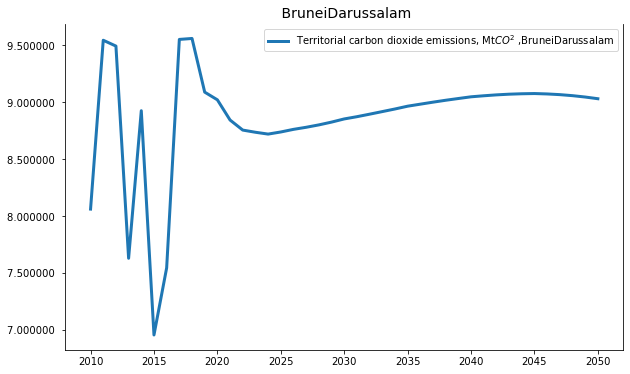

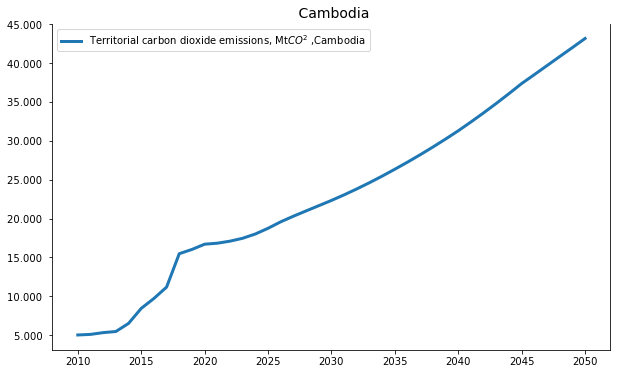

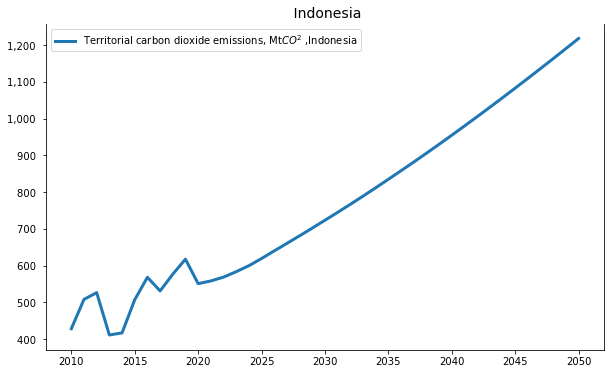

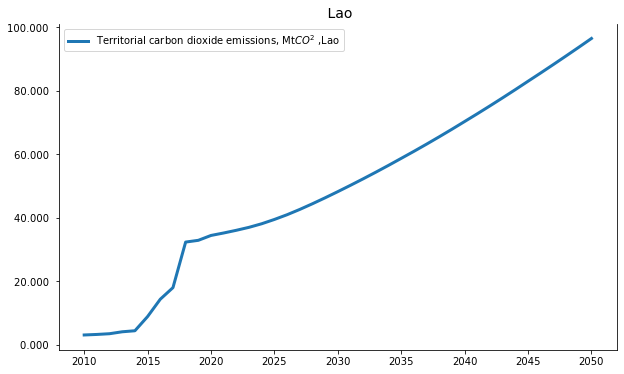

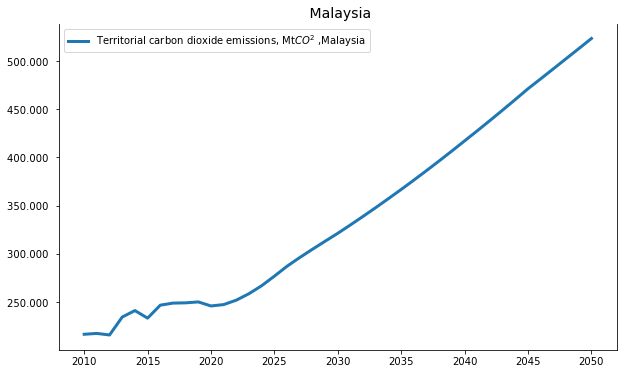

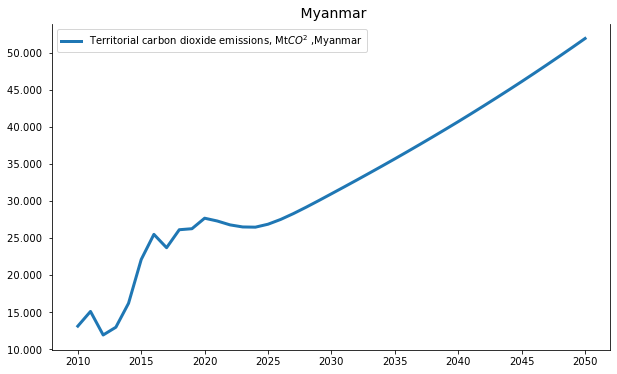

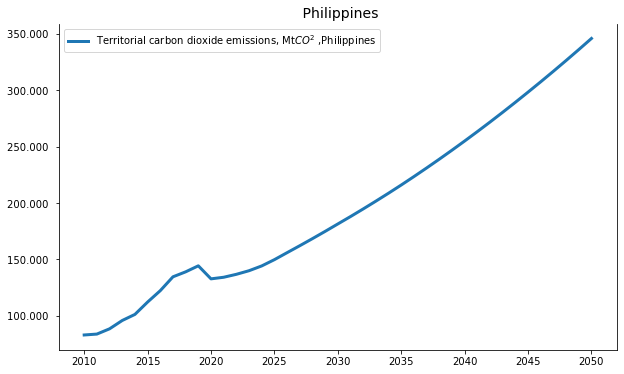

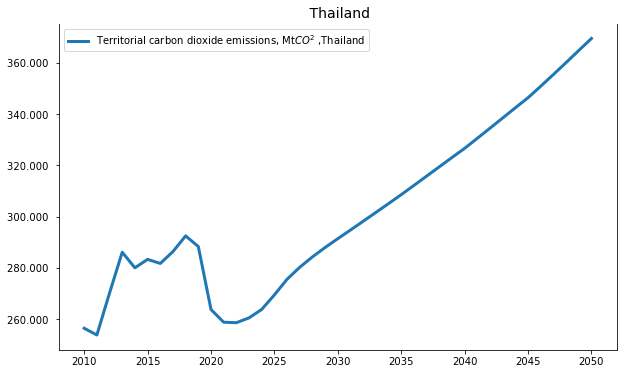

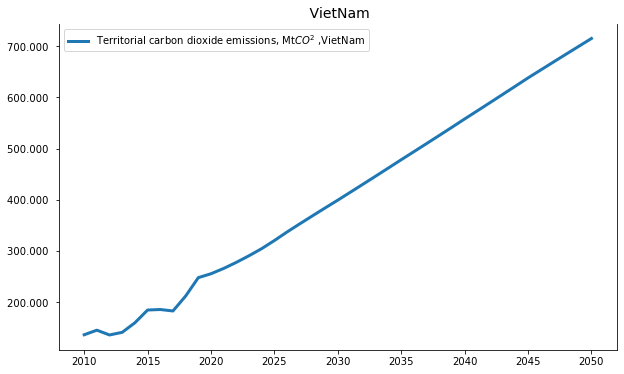

In [7]:
for t in target_var:
    model.plot_basis(masia.get_a_country(t),df = masia.basedf.loc[2010:,[t]].rename(columns=masia.var_description),legend=1);

# Carbon tax in Business as usual scenario

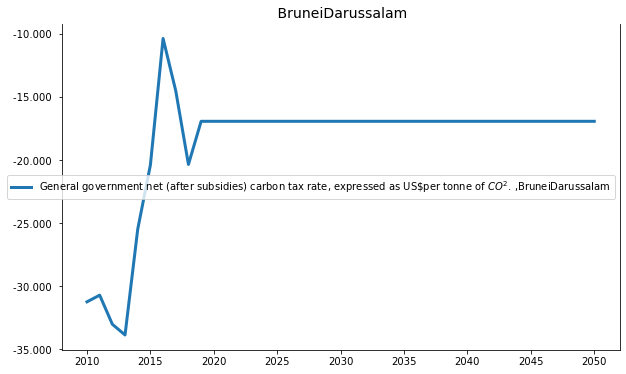

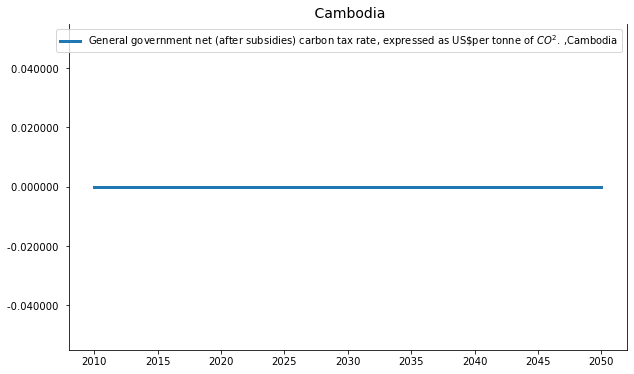

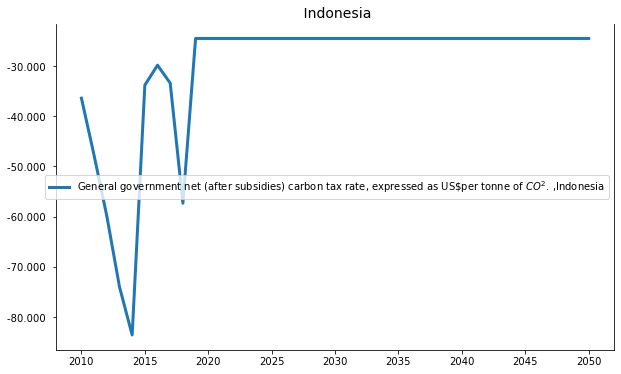

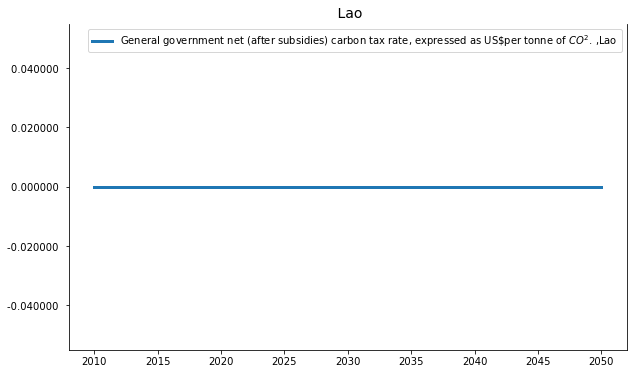

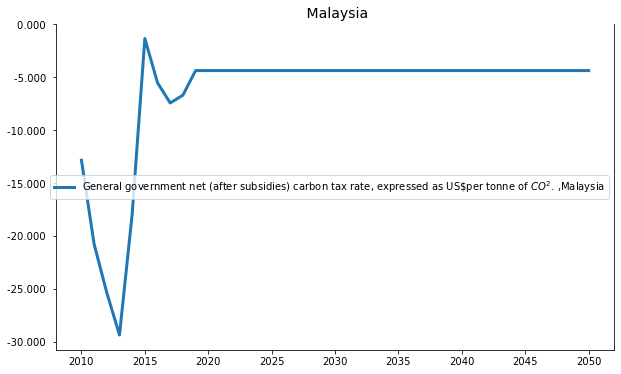

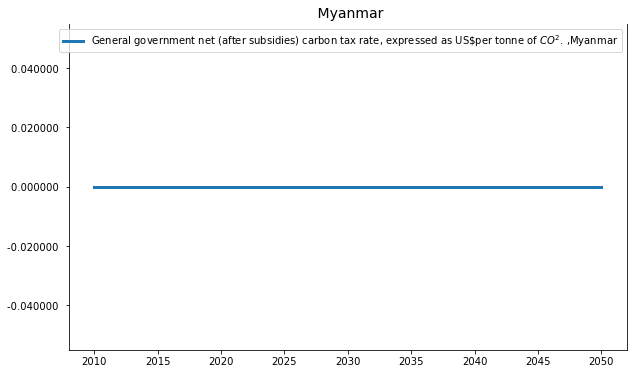

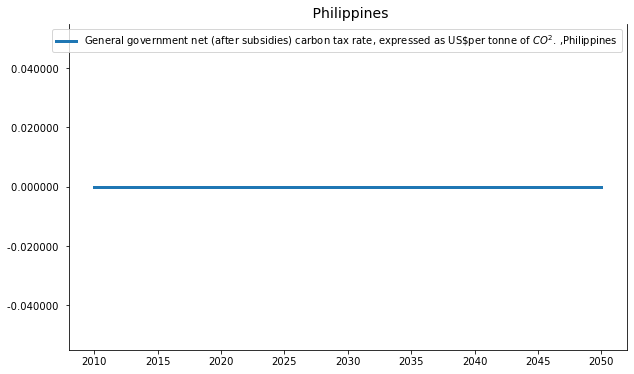

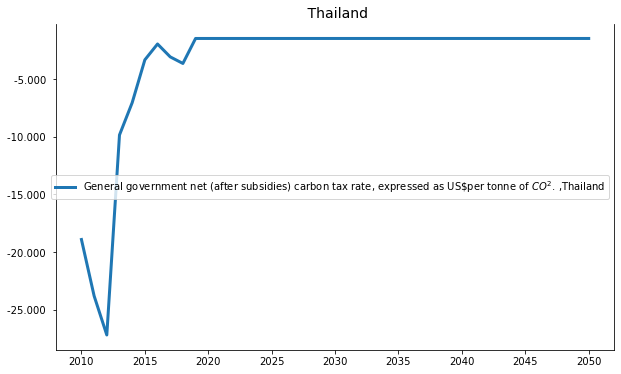

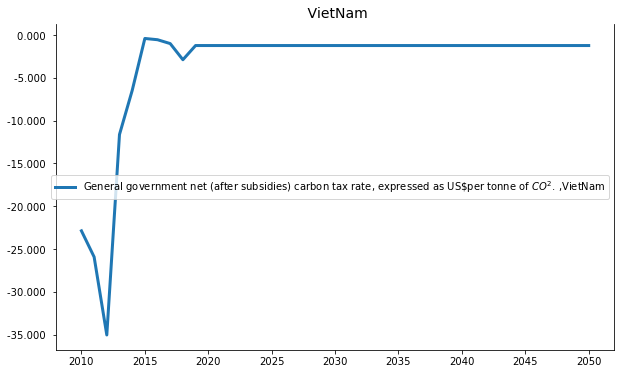

In [8]:
for i in instruments: 
    tax = [i[0][:-2]]
    model.plot_basis(masia.get_a_country(tax[0]),df = masia.basedf.loc[2010:,tax].rename(columns=masia.var_description),legend=1);

# Lets look at the impact of increasing the tax with \$10/tonne  in 2022

In [9]:
experiment = baseline.copy()
experiment.loc[2022,instrumentlist]= experiment.loc[2022,(instrumentlist := [i[0] for i in instruments])] + 10 
result = masia(experiment,progressbar = 0,silent=1)

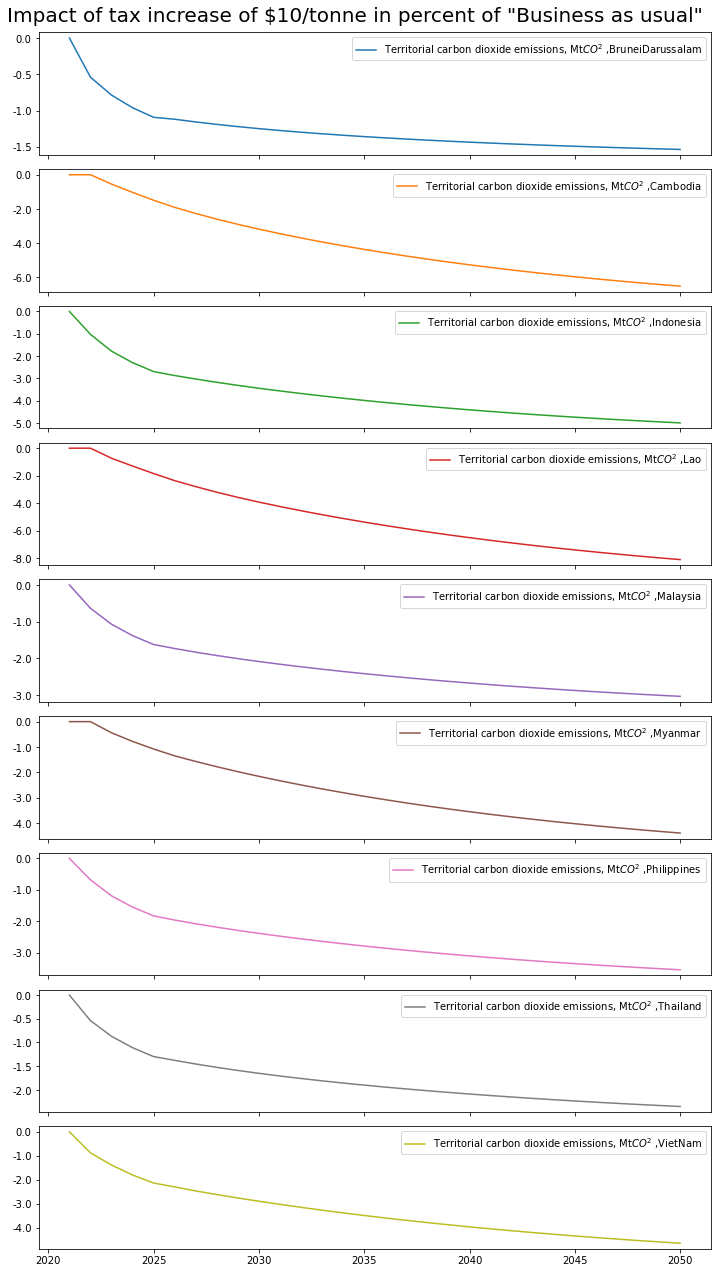

In [10]:
masia[target_var].difpctlevel.mul100.rename().plot(colrow  = 1,title = 'Impact of tax increase of \$10/tonne in percent of "Business as usual"  ',top=0.96,sharey=0,dec=2);
end_pct = masia[target_var].difpctlevel.mul100.df.loc[2050,:]
    

# The impact in selectet years  of increasing the tax with 10/tonne in 2022 in percent of BAU

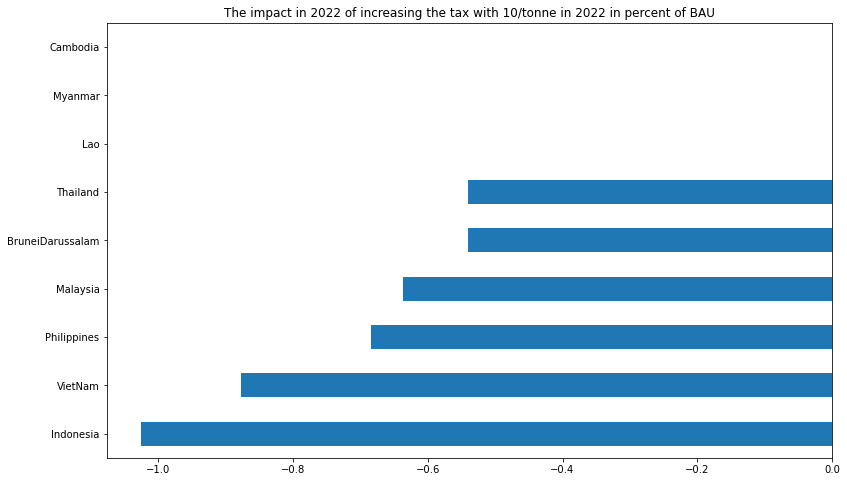

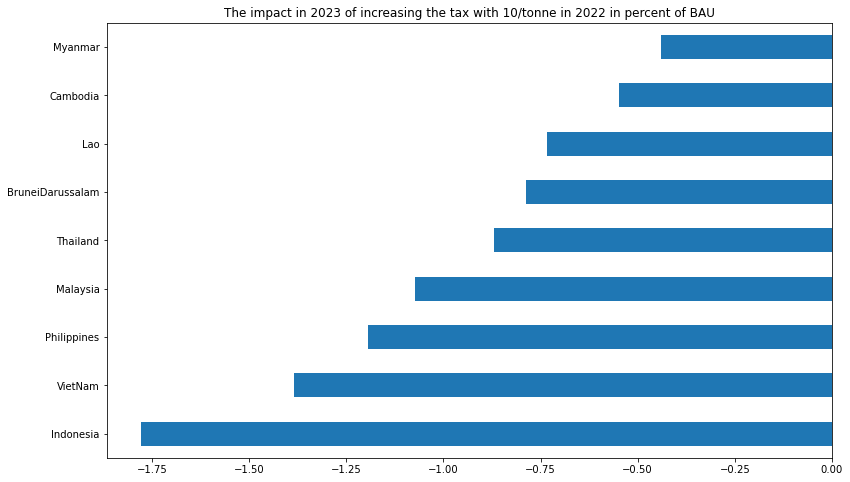

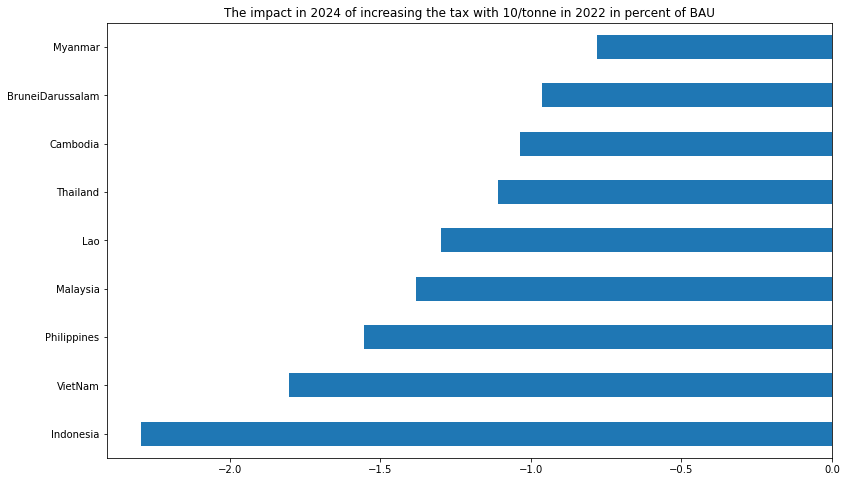

In [11]:

for year in [2022,2023,2024]:
    end_pct = masia[target_var].difpctlevel.mul100.df.loc[year,:]
    fig= end_pct.T.rename(masia.get_a_country).sort_values().plot(kind='barh',figsize = (13,8),title=f'The impact in {year} of increasing the tax with 10/tonne in 2022 in percent of BAU')
    plt.show()

# Find for each country the emission growthrate which is consistent with a the desired reduction in emmision in 2050 

In [12]:
bau_2050 = baseline.loc[2050, target_var]
bau_2022  = baseline.loc[2022, target_var]

org_growthrate = (bau_2050/bau_2022)**(1/(2050-2022))
org_growthrate.name = 'Original growth rate'

target_2050 = bau_2050*(1-reduction_percent/100)
target_2050.name= 'target'

target_growthrate = (target_2050/bau_2022)**(1/(2050-2022))
target_growthrate.name = 'Target growth rate'

In [13]:
target_growth_values = list(target_growthrate.values)

In [14]:
target_before = baseline[target_var].loc[2022:,:]
calclines = '\n'.join(f'{t} = {t}(-1) * {v}' for t,v in zip(target_var,target_growth_values))
target = target_before.mfcalc(calclines).loc[2022+delay:,:]

In [15]:
outdf = pd.DataFrame([bau_2022,bau_2050,target_2050,target.loc[2050,: ],org_growthrate,target_growthrate])
print(outdf.T)

               2022         2050      target        2050  \
BRN_CO2    8.755168     9.030840    6.321588    6.321588   
KHM_CO2   17.091480    43.151550   30.206085   30.206085   
IDN_CO2  568.703700  1218.279002  852.795301  852.795301   
LAO_CO2   35.975220    96.393180   67.475226   67.475226   
MYS_CO2  251.956600   523.385200  366.369640  366.369640   
MMR_CO2   26.750860    51.907150   36.335005   36.335005   
PHL_CO2  136.737200   345.827201  242.079040  242.079040   
THA_CO2  258.589600   369.446700  258.612690  258.612690   
VNM_CO2  277.603300   715.051501  500.536051  500.536051   

         Original growth rate  Target growth rate  
BRN_CO2              1.001108            0.988436  
KHM_CO2              1.033629            1.020546  
IDN_CO2              1.027582            1.014575  
LAO_CO2              1.035827            1.022716  
MYS_CO2              1.026453            1.013461  
MMR_CO2              1.023957            1.010996  
PHL_CO2              1.033694      

# Show the target developement in emision 

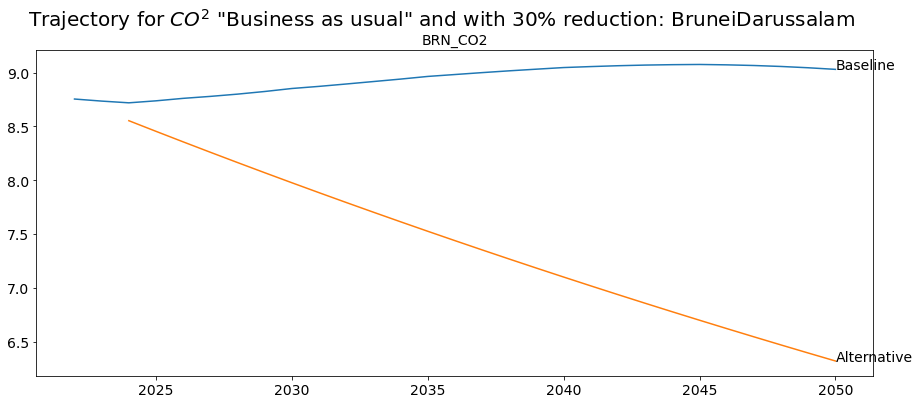

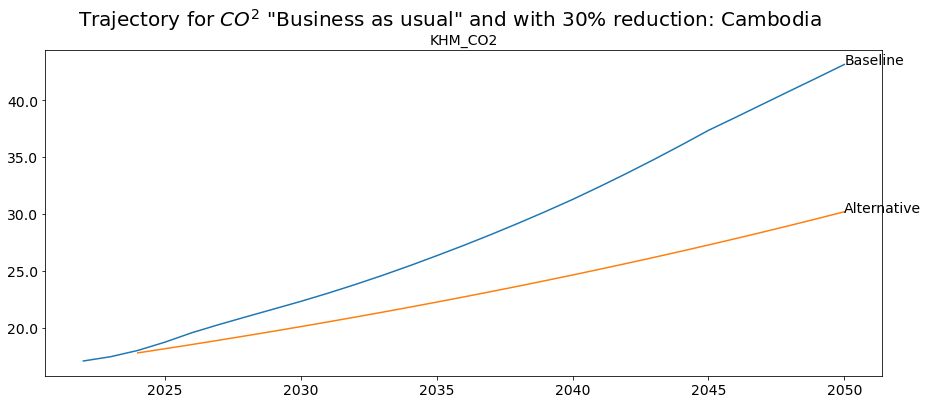

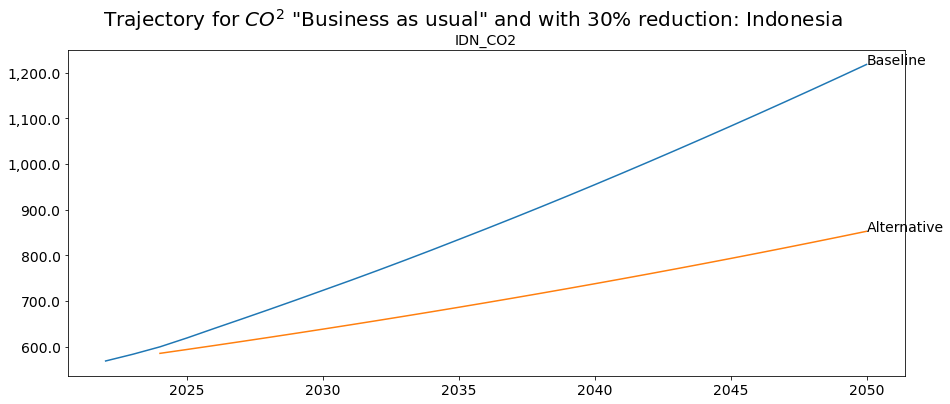

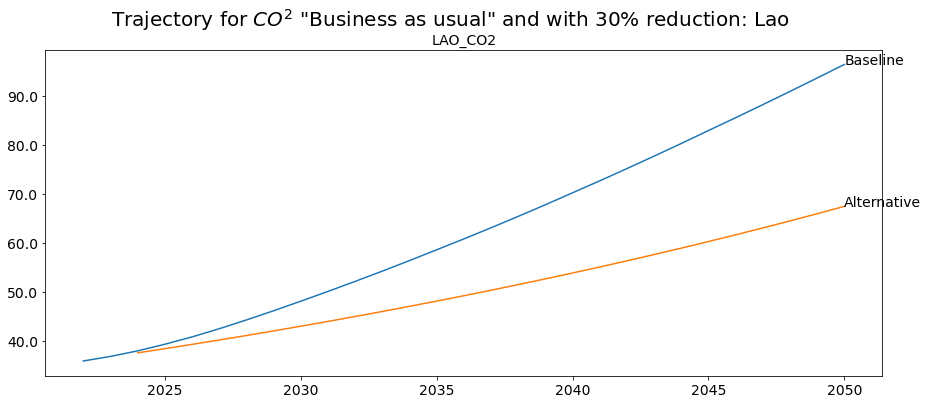

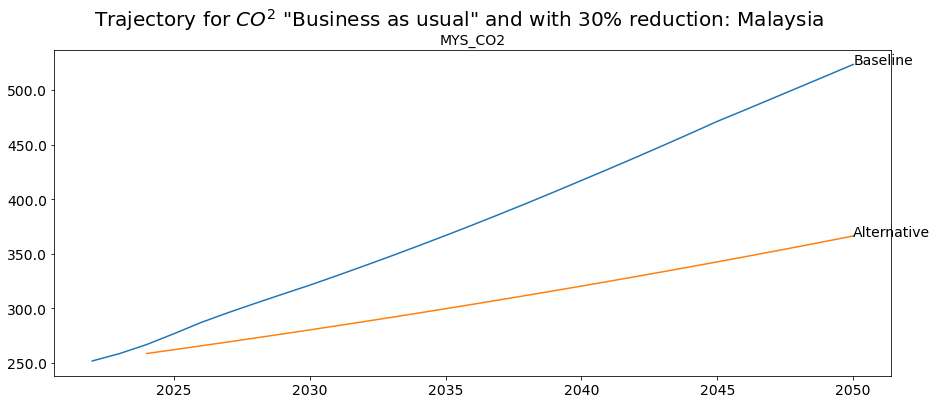

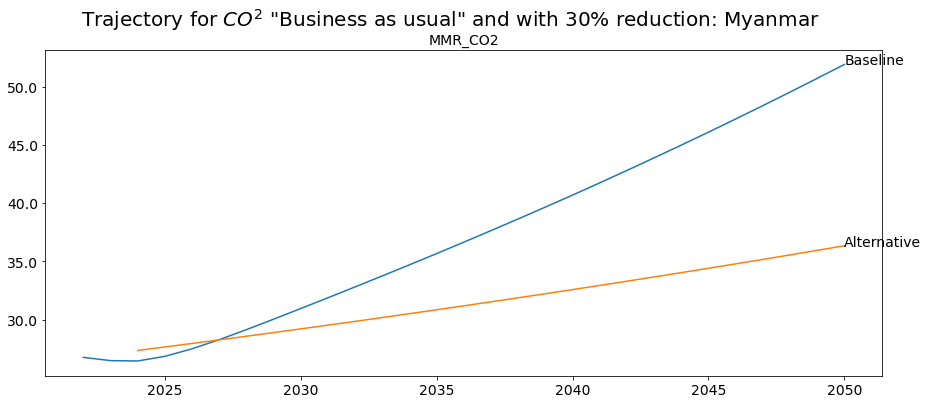

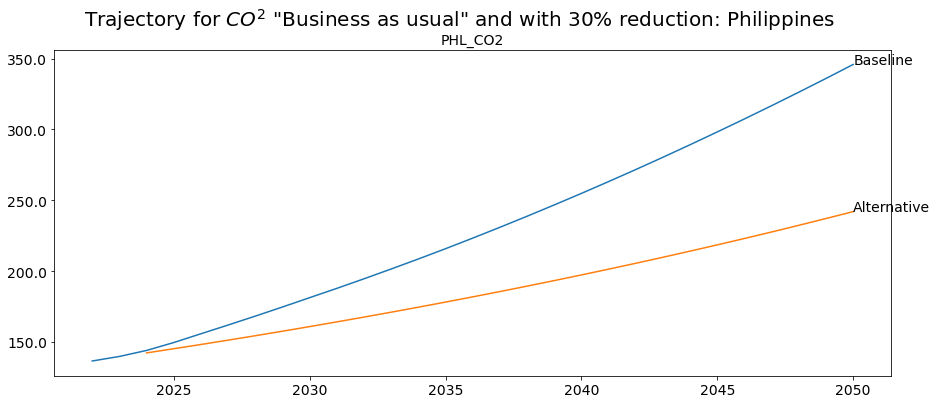

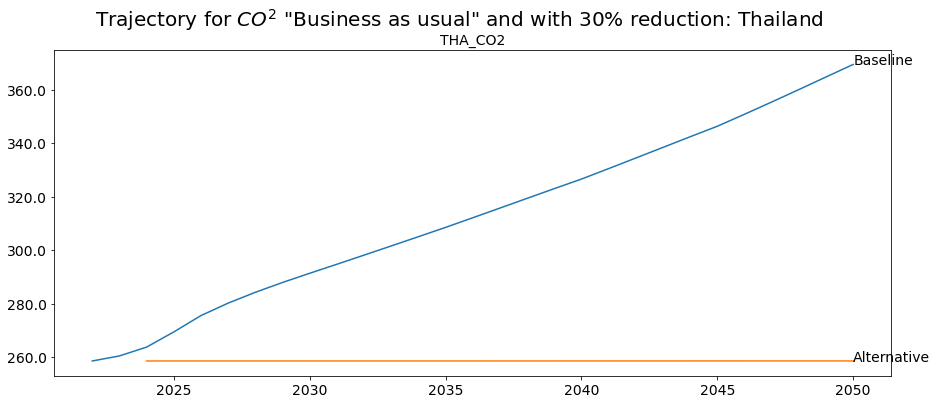

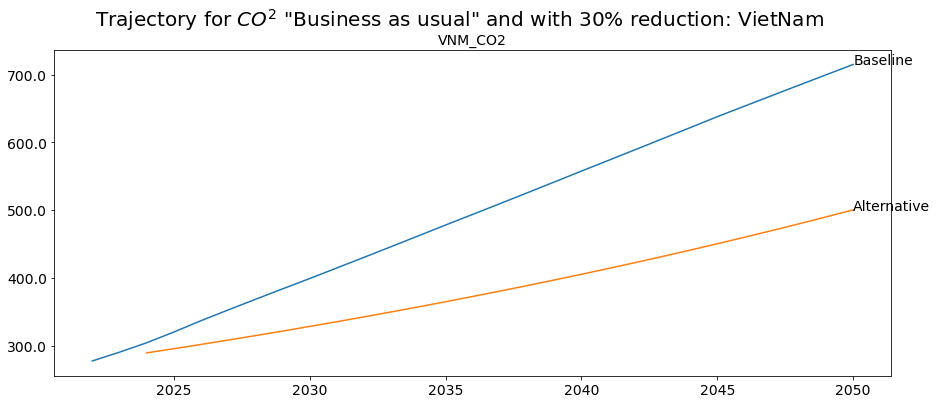

In [16]:
from modelvis import vis_alt
inject(masia)  

for t in target_var:
    grund  = target_before.loc[2020:,[t]]
    mul    = target.loc[2020:,[t]]
    vis_alt(grund,mul,title=f'Trajectory for $CO^2$ "Business as usual" and with {reduction_percent}% reduction: {masia.get_a_country(t)}',top=0.88)
    

# Setup the Target/instrument device

In [17]:
t_i_baseline = baseline.copy()
t_i = targets_instruments(databank=t_i_baseline,targets=target,instruments=instruments,
                          model=masia,DefaultImpuls=10,defaultconv=0.5,varimpulse=True,nonlin=4,silent=1)

# Run the device. 
And fetch a cup of coffee. 
Serious calculations are to be performed

In [18]:
t_i.debug=0
res = t_i(delay=delay,shortfall=0)

Finding instruments :   0%|          | 0/27

# So close to the target
Below the difference between the target $co^2$ and the simulation result

This should reflect the size of defaultconv in the target_instrument call 

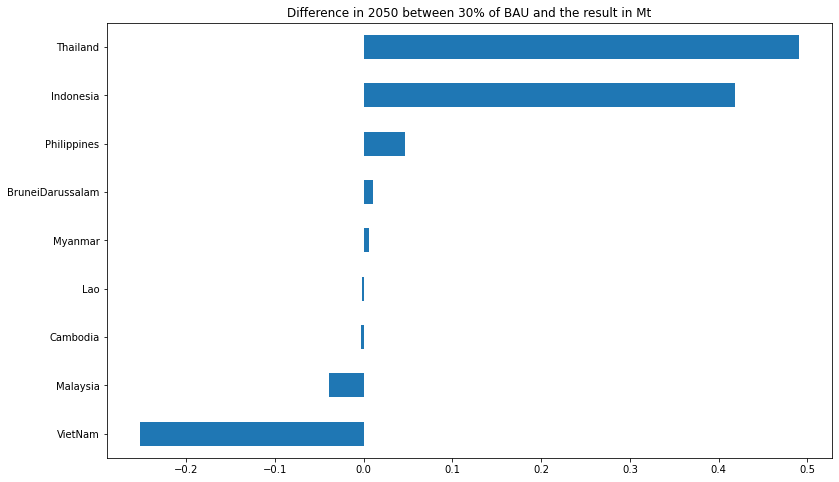

In [19]:
fig= (masia.lastdf.loc[2050,target_var]-target.loc[2050,:]).rename(masia.get_a_country).sort_values().plot(kind='barh',figsize = (13,8),title=f'Difference in 2050 between {reduction_percent}% of BAU and the result in Mt')
plt.show()

# Emission and tax in "Business as usual" and target run  

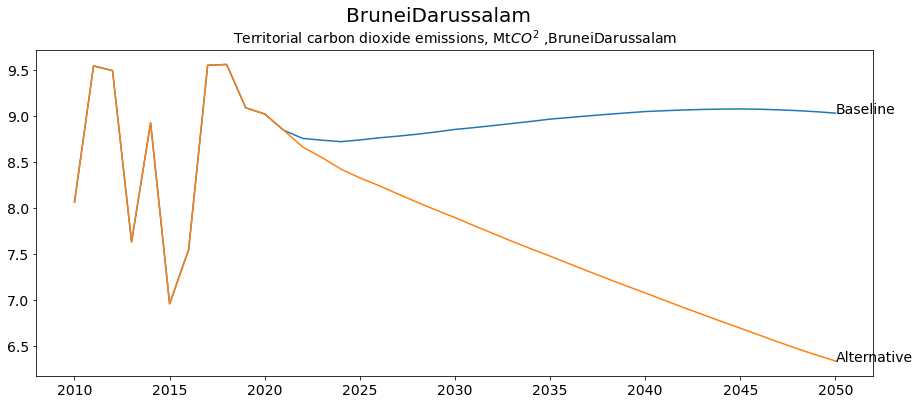

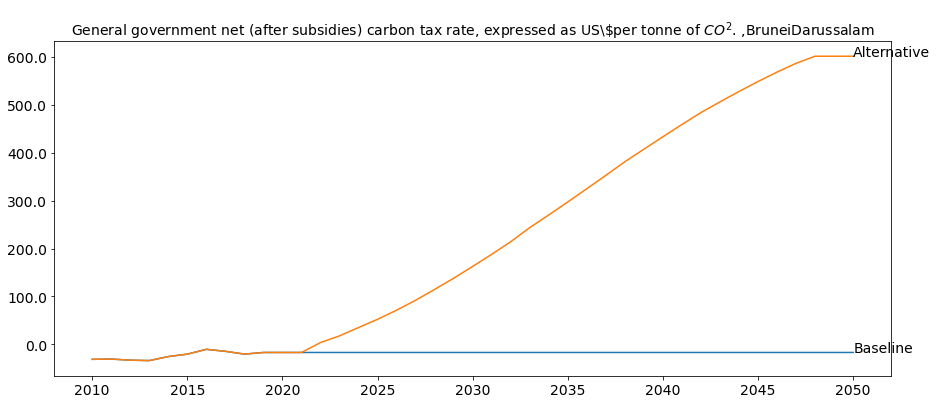

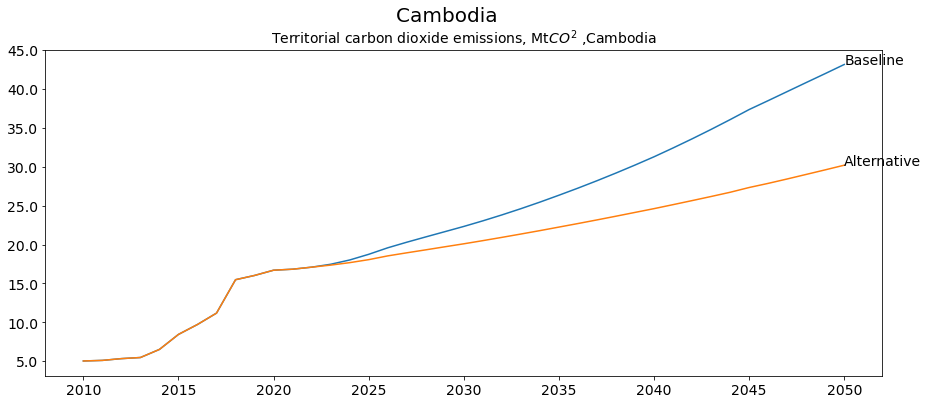

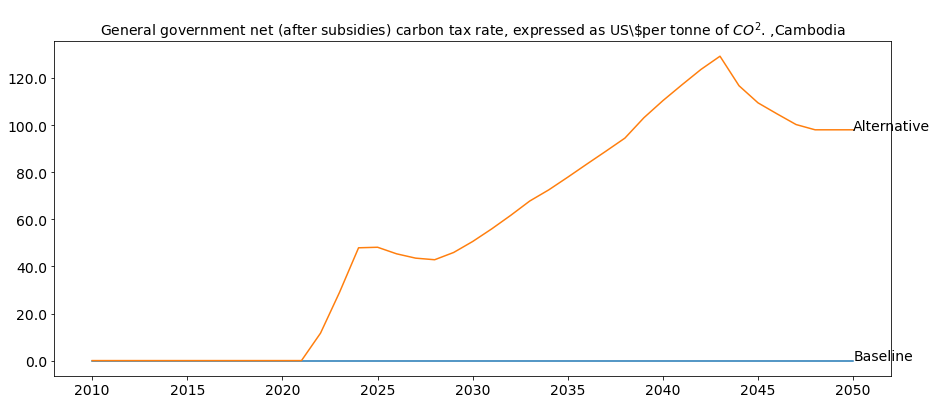

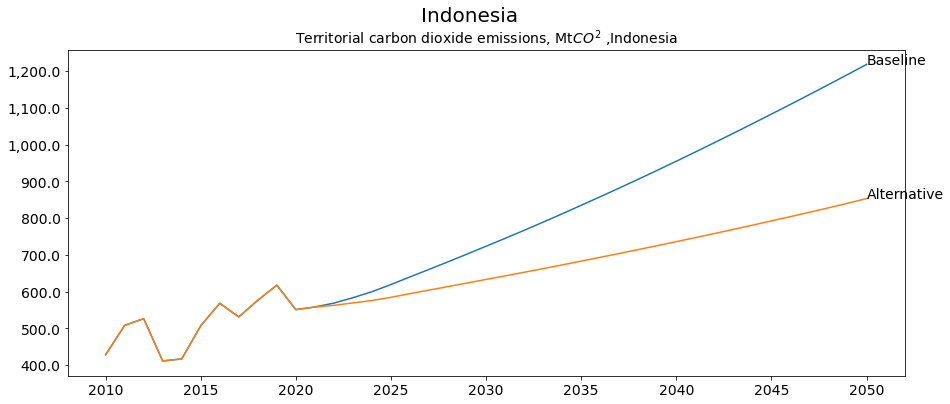

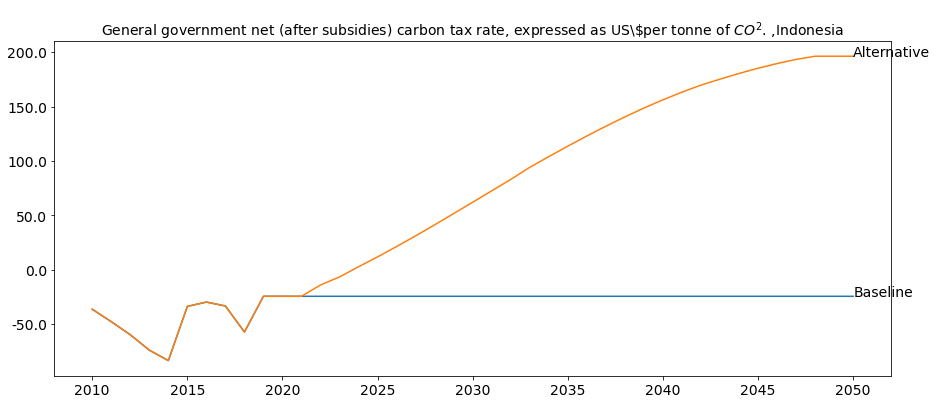

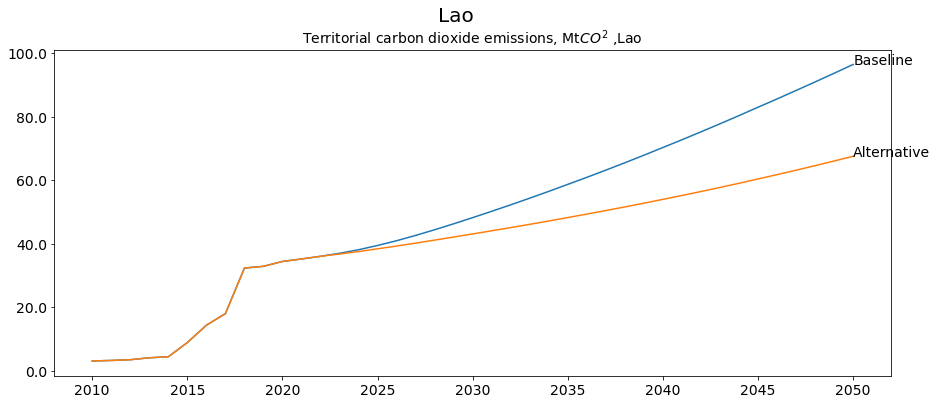

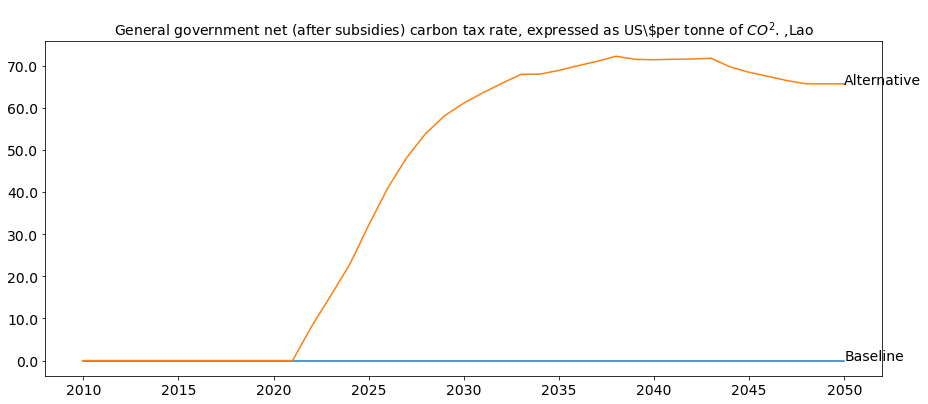

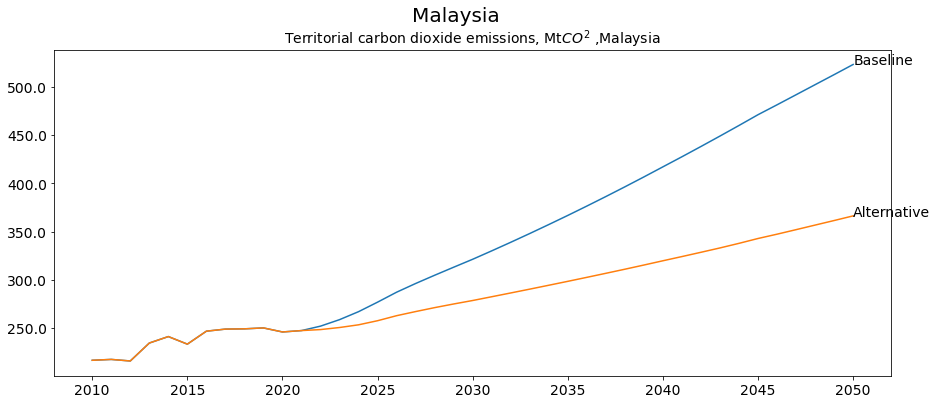

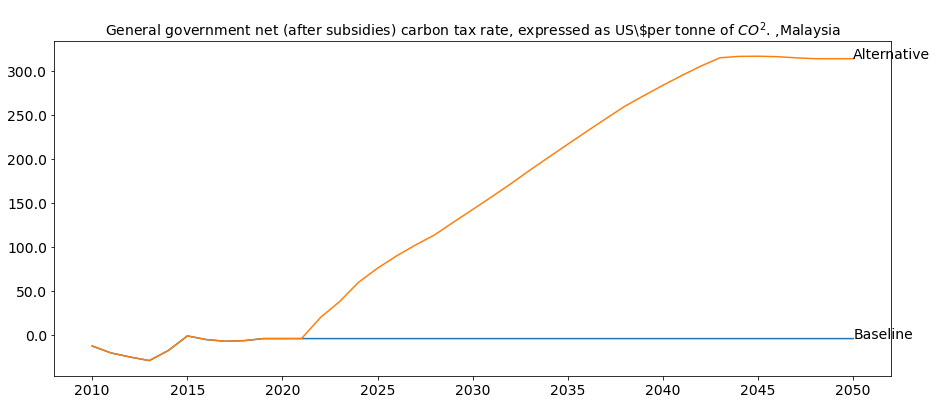

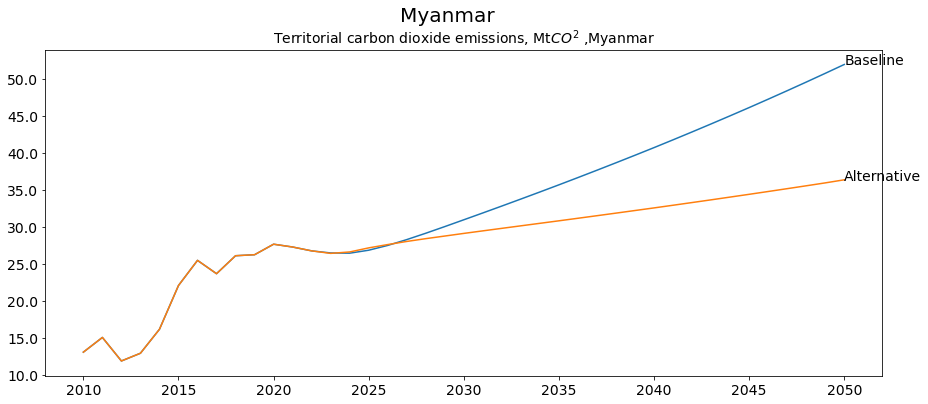

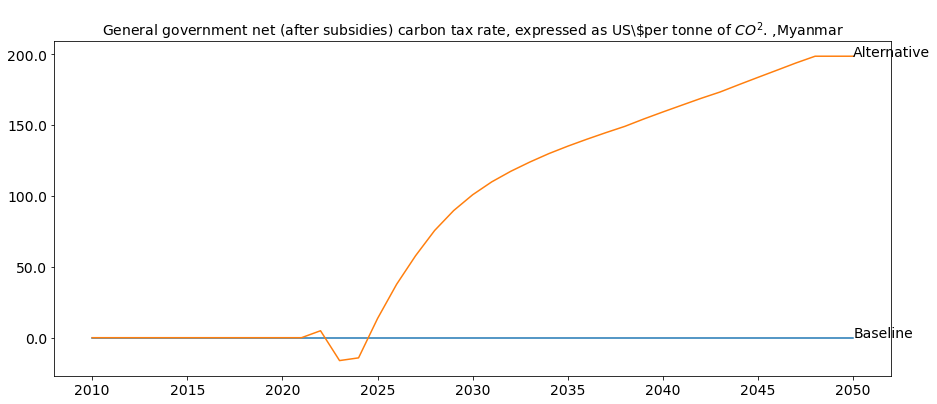

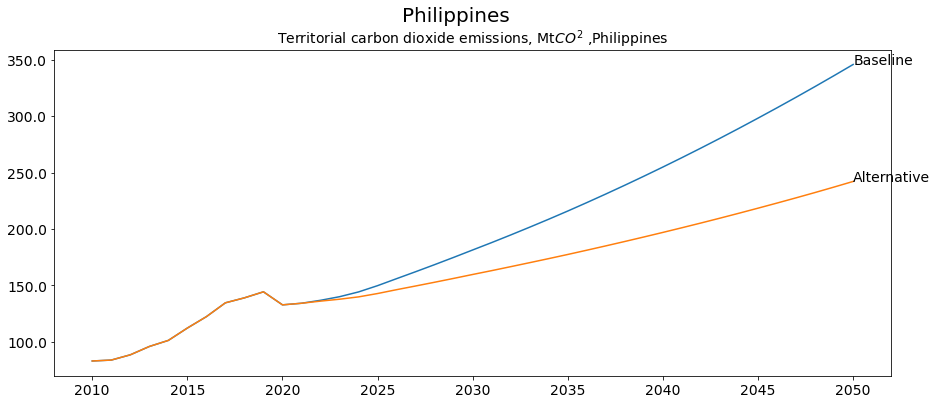

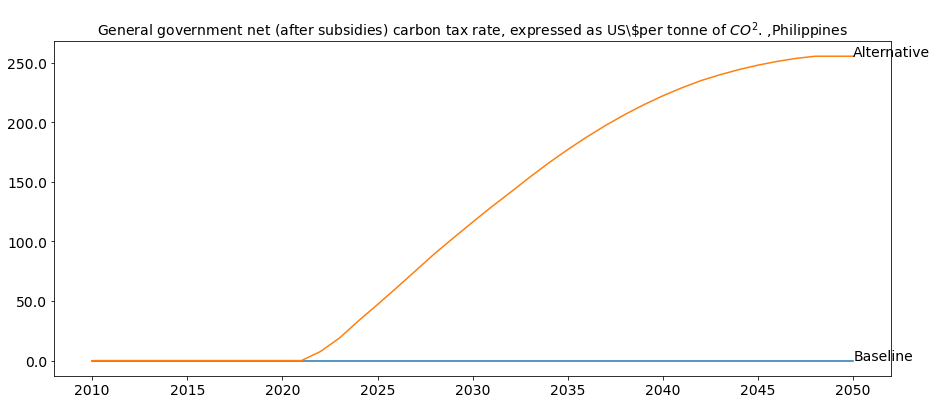

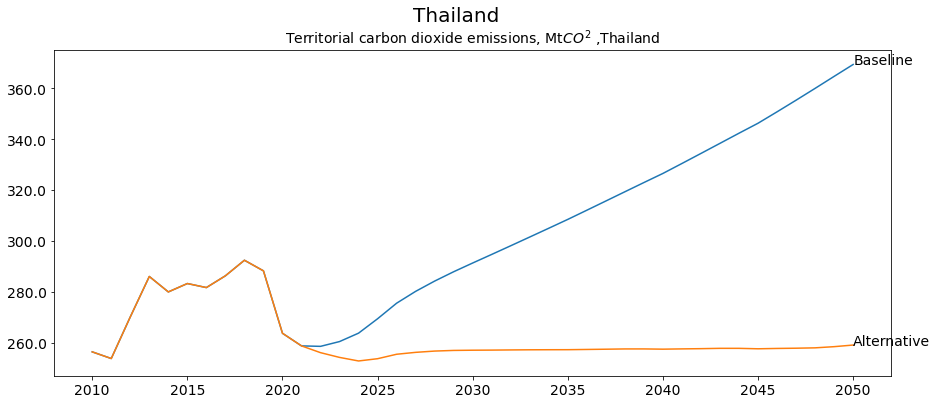

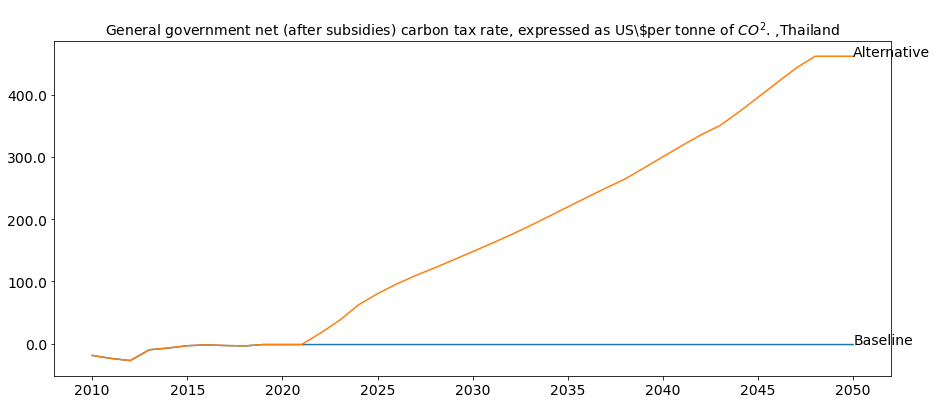

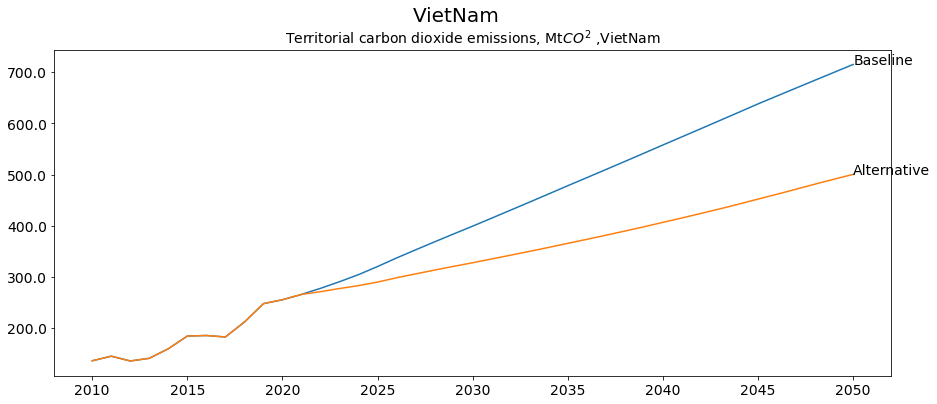

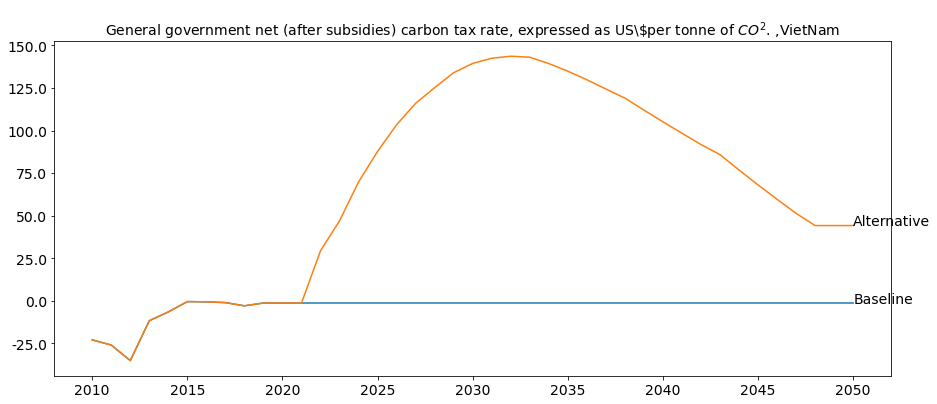

In [20]:
with masia.set_smpl(2010,2050):
    for country in countries_of_interest:
        masia[f'{country}_co2' ].plot_alt(title=f'{masia.iso_dict[country]} ',top=0.88);        
        masia[f'{country}_GCARBR' ].plot_alt(title=f' ',top=0.90);